# Variational autoencoder
This notebook will investiga

In [1]:
import os
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
  
print("Is in Colab: ", IN_COLAB)
if IN_COLAB:
    os.system('git clone https://github.com/AllaVinner/JL-ML.git')
    os.system('pip install -e JL-ML')
    # Needed for colab to find the JL-ML directory
    import site
    site.main()

model_path = '../saved-models/' if not IN_COLAB else 'JL-ML/saved-models' 

Is in Colab:  False


In [2]:

import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from collections import defaultdict

from jlauto.models.variational_autoencoder import VariationalAutoencoder
from jlauto.models.autoencoder import Autoencoder
from jlauto.models.continuous_bernoulli_loss import continuous_bernoulli_loss

# For dimension reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# for visualization and evaluation
from jlauto.visual.latent_plane_mosaic import LatentPlaneMosaic
from jlauto.visual.latent_interpolation_mosaic import LatentInterpolationMosaic
from jlauto.visual.sample_scatter_gui import SampleScatterGUI

In [3]:
names = ['ae_latent_dim_4']
paths = [model_path+name for name in names]
types = ['ae' for name in names]

model_df = pd.DataFrame(data = {
    'path' : paths,
    'ae_type' : types,
    },
    index = names,
)


In [4]:
models = []
for name, model in model_df.iterrows():
    if model['ae_type'] == "ae":
        models.append(keras.models.load_model(model['path'], 
                         custom_objects={"Autoencoder": Autoencoder,
                                         "continuous_bernoulli_loss": continuous_bernoulli_loss}))
    elif model['ae_type'] == "vae":
        models.append(keras.models.load_model(model['path'], 
                                 custom_objects={"VariationalAutoencoder": VariationalAutoencoder,
                                                 "continuous_bernoulli_loss":  continuous_bernoulli_loss}))
model_df['model'] = models    
model_df.head()

,path,ae_type,model
ae_latent_dim_4,../saved-models/ae_latent_dim_4,ae,<jlauto.models.autoencoder.Autoencoder object ...


In [7]:
num_models = model_df.shape[0]
latent_dim = 4

## Preprocess data


In [9]:
(_, _), (test_digits, test_labels) = keras.datasets.mnist.load_data()
test_digits = np.expand_dims(test_digits, -1).astype("float32") / 255
input_shape = test_digits.shape[1:]
num_test = test_labels.shape[0]

## Load Variational autoencoder

### Print setup details

## Reconstruct and dimension reductions

In [10]:
# Fill
digit_df_list = []
dimension_df_list = []
#latent_df_list = []


for name, model in model_df.iterrows():
    print(name)
    if model['ae_type'] == "ae":
        code = model['model'].encoder(test_digits).numpy()
        code_std = np.empty(shape = code.shape)*np.nan
        
    elif model['ae_type'] == "vae":
        digit_distribution = model['model'].encoder(test_digits).numpy()
        code = digit_distribution[:,0,:]
        code_std = np.sqrt(np.exp(digit_distribution[:,1,:]))
    
    # Caclualte digit_df data
    digit_distance = np.linalg.norm(code, axis = 1)
    digit_radius = np.power(np.prod(code_std, axis = 1),1/latent_dim)
    digit_loss = tf.reduce_mean(tf.reduce_mean(tf.keras.losses.binary_crossentropy(test_digits, model['model'](test_digits)),axis = -1),axis = -1).numpy()
    digit_tsne = TSNE(n_components = 2).fit_transform(code)
    
    _digit_df = pd.DataFrame(data = {
        'model_name' : name,
        'label' : test_labels,
        'loss' : digit_loss,
        'distance' : digit_distance,
        'radius' : digit_radius,
        'tsne_0' : digit_tsne[:,0],
        'tsne_1' : digit_tsne[:,1],
    })
    digit_df_list.append(_digit_df)   
    
    
    # Calculate dimension_df data
    value_spread = np.nanstd(code, axis = 0)
    spread_mean = np.nanmean(code_std, axis = 0)
    dim_index = np.arange(latent_dim)
    
    _dimension_df = pd.DataFrame(data = {
        'model_name' : name,
        'dim_index' : dim_index,
        'value_spread' : value_spread,
        'spread_mean' : spread_mean,
    })
    
    dimension_df_list.append(_dimension_df)
    """
    # Calculate latent_df data
    latent_labels = test_labels.repeat(repeats = latent_dim)
    latent_digit_index = np.arange(num_test).repeat(repeats = latent_dim)
    latent_dim_index = np.tile(np.arange(latent_dim), num_test)
    latent_value = code.reshape(-1)
    latent_spread = code_std.reshape(-1)
    
    _latent_df = pd.DataFrame(data = {
        'model_name' : name,
        'label' : latent_labels,
        'digit_index' : latent_digit_index,
        'dim_index' : latent_dim_index,
        'value' : latent_value,
        'spread' : latent_spread
    })
    
    latent_df_list.append(_latent_df)
    """
    
        
digit_df = pd.concat(digit_df_list)
dimension_df = pd.concat(dimension_df_list)
#latent_df = pd.concat(latent_df_list)

ae_latent_dim_4


C:\Users\joelw\miniconda3\envs\jenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\joelw\miniconda3\envs\jenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\joelw\AppData\Local\Temp/ipykernel_18936/2189642502.py:38: RuntimeWarning: Mean of empty slice
  spread_mean = np.nanmean(code_std, axis = 0)


<ipython-input-15-f7eddffb12ed>:15: RuntimeWarning: Mean of empty slice
  spread_mean = np.nanmean(code_std, axis = 0)


## Investigation

In [11]:
model_df.head()

,path,ae_type,model
ae_latent_dim_4,../saved-models/ae_latent_dim_4,ae,<jlauto.models.autoencoder.Autoencoder object ...


### Show reconstructions

In [12]:
digit_df.head()

,model_name,label,loss,distance,radius,tsne_0,tsne_1
0,ae_latent_dim_4,7,0.228915,11.737018,NaN,21.178831,-5.679305
1,ae_latent_dim_4,2,0.351312,10.227135,NaN,-22.852423,40.362652
2,ae_latent_dim_4,1,0.153927,14.441329,NaN,83.845665,-5.641282
3,ae_latent_dim_4,0,0.284458,8.983508,NaN,19.021927,-36.242203
4,ae_latent_dim_4,4,0.230943,10.437706,NaN,-18.305784,76.765205


In [14]:
dimension_df.head()

,model_name,dim_index,value_spread,spread_mean
0,ae_latent_dim_4,0,1.288222,NaN
1,ae_latent_dim_4,1,0.950172,NaN
2,ae_latent_dim_4,2,0.909271,NaN
3,ae_latent_dim_4,3,1.001947,NaN


In [12]:
latent_df.head()

,model_name,label,digit_index,dim_index,value,spread
0,ae,7,0,0,8.920861,NaN
1,ae,7,0,1,2.935239,NaN
2,ae,7,0,2,0.101040,NaN
3,ae,7,0,3,3.835251,NaN
4,ae,7,0,4,5.167331,NaN


In [15]:
def plot_mnist_comparison(images, figsize=None, row_labels=None):
  # images: (images_1, ..., images_n)
  # images_1.shape: (5, 28, 28, 1)
  
  """
  Example usage:
  
  images_original = x_test[:5, :, :, :]
  images_decoded = autoencoder(images_original)
  
  plot_mnist_comparison((images_original, images_decoded), figsize=(28, 8), row_labels=['original', 'decoded'])
  
  """

  nbr_rows = images[0].shape[0]
  nbr_rows = len(images)

  fig = plt.figure(figsize=figsize)
  fig.subplots_adjust(hspace=0, wspace=0)

  for row, row_images in enumerate(images):

    images_concat = np.concatenate(row_images[:,:,:,0], axis=1)
    
    ax = plt.subplot(nbr_rows, 1, row+1)
    fig_temp = plt.imshow(images_concat, cmap='bone', vmin=0, vmax=1)

    ax.get_xaxis().set_visible(False)

    if row_labels is not None: ax.set_ylabel(row_labels[row])

    ax.set_yticks([])
  
  plt.show()

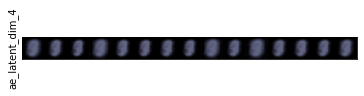

In [16]:
num_img = 15
rec_index = rnd.randint(num_test,size =(num_img,) )
digits = test_digits
digits = digits[rec_index]
img_list = []

i = 0
for name, model in model_df.iterrows():
    rec = model['model'](digits).numpy()
    img_list.append(rec)
    i = i+1

plot_mnist_comparison(img_list, row_labels = names)

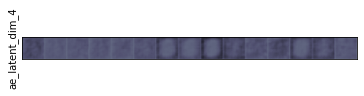

In [17]:
num_img = 15
mean = np.zeros(latent_dim)
cov  = 1*np.eye(latent_dim)
latent_points = rnd.multivariate_normal(mean, cov, size = (num_img,))

img_list = []
i = 0
for name, model in model_df.iterrows():
    rec = model['model'].decoder(latent_points).numpy()
    img_list.append(rec)
    i = i+1


plot_mnist_comparison(img_list, row_labels = names)

### Latent

In [18]:

indeces = rnd.randint(num_test,size = (3,))
indeces = [1,2,3]
ul = test_digits[indeces[0]]
ur = test_digits[indeces[1]]
dl = test_digits[indeces[2]]
z =  np.zeros(dl.shape)
corner_image = np.concatenate( (np.concatenate((ul,ur),axis = 1),
                                np.concatenate((dl,z ),axis = 1)), axis = 0)


<AxesSubplot:>

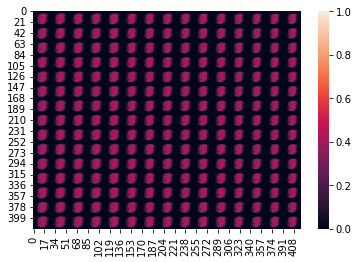

In [20]:

model = model_df.loc['ae_latent_dim_4','model']
mosaic = LatentInterpolationMosaic(
                          model.encode,
                          model.decoder,
                          test_digits,
                          indeces,
                          num_row = 15,
                          num_col = 15).mosaic



sns.heatmap(mosaic[:,:,0], vmin = 0, vmax = 1)

### Scatter

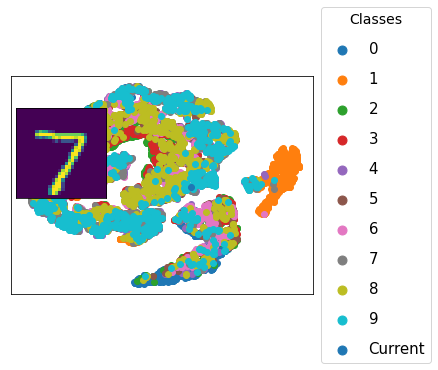

In [21]:
model_name = 'ae_latent_dim_4'
scatter = digit_df[digit_df['model_name']==model_name][['tsne_0', 'tsne_1']].to_numpy()
SampleScatterGUI(scatter, test_labels, test_digits)


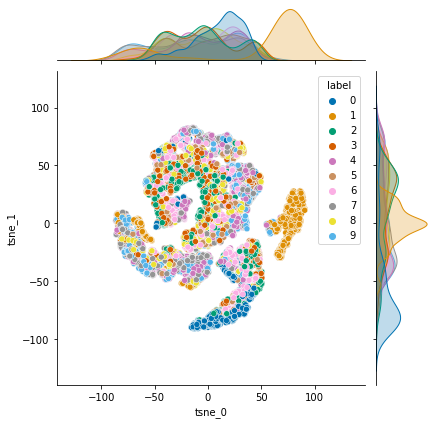

In [22]:
model_name = "ae_latent_dim_4"
sns.jointplot(data = digit_df[digit_df['model_name'] == model_name ], x = 'tsne_0', y = 'tsne_1',
              hue = 'label',
              palette = 'colorblind')

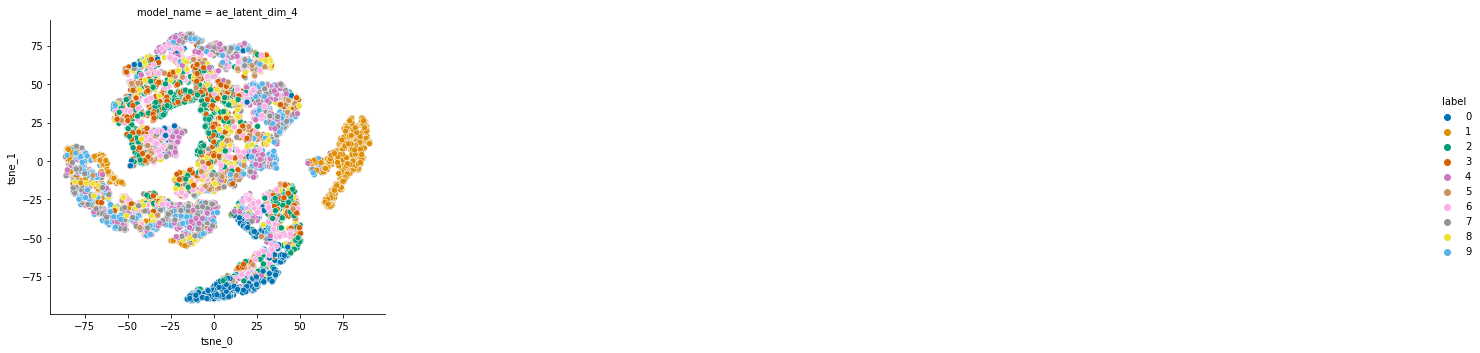

In [23]:
model_name = "ae_latent_dim_4"
sns.relplot(data = digit_df, x = 'tsne_0', y = 'tsne_1',
              hue = 'label',
              palette = 'colorblind',
              kind = 'scatter',
              col = 'model_name',
              col_wrap = 4,
           )

### Spread

Here we have that the first 6 principal axises are almost one and the remaining 4 are almost zero (e-3). This is combination with that the cross covariance seem to be super much zero (e-15), indicates that we have a six dimesnioal sphere in this ten dimesional latent space. Interesting to see is also if you create a latent vector in the pca-vector space. Then comparing the latent value in each dimension times the spread in each dimension, gives you the importance of that dimension in that latent point. A low importance will not have an effect on the output (kind of like a low derivative...), while a hight value will give a big difference.

In [24]:
axis_index = [0,-1]
scaling_factors = np.array([2,2])

In [25]:
model_name = 'ae_latent_dim_4'
model = model_df.loc[model_name, 'model']
latent_vectors = model_df.loc[model_name, 'latent_base'][axis_index]
latent_origin  = model_df.loc[model_name, 'latent_mean']
mosaic = LatentPlaneMosaic(model.decoder,
                  latent_vectors = (scaling_factors*latent_vectors.T).T,
                  latent_origin = latent_origin,
                  num_row = 20,
                  num_col = 20).mosaic

#fig,ax = plt.subplots(1,1)
#ax.imshow(mosaic)
sns.heatmap(mosaic[:,:,0], vmin = 0, vmax = 1)

KeyError: 'latent_base'

## Spred 

### Latent dataframe stats

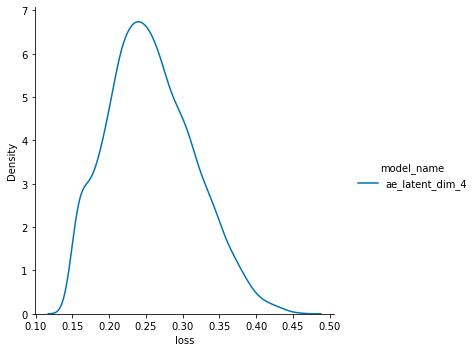

In [26]:
sns.displot(data = digit_df, x = 'loss', hue = 'model_name', kind = 'kde', palette = 'colorblind')

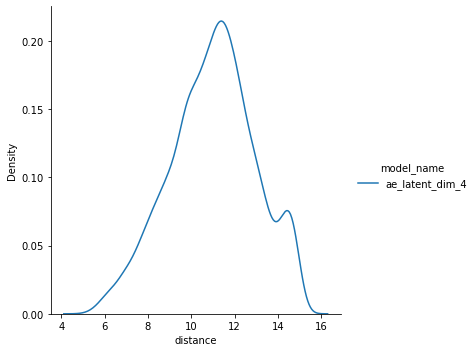

In [27]:
sns.displot(data = digit_df, x = 'distance',hue = 'model_name', kind = 'kde')

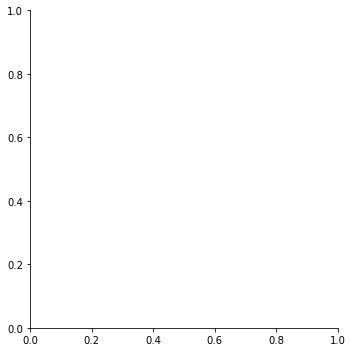

In [28]:
sns.displot(data = digit_df, x = 'radius',hue = 'model_name', kind = 'kde')

### Summary dataframe plot

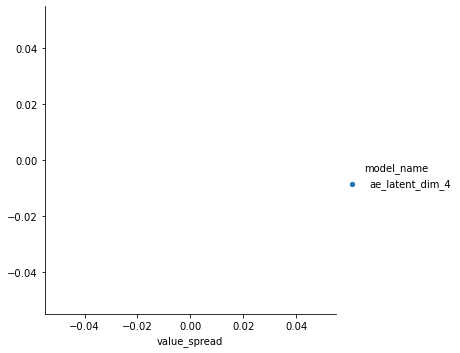

In [29]:
######### IMPORTANT ########
sns.relplot(data = dimension_df, x = 'value_spread',
            y = 'spread_mean',
            hue = 'model_name',
           size = 'model_name',
           )

### dimension dataframe plots

In [30]:
sns.relplot(data = latent_df,
           x = 'value',
           y = 'spread',
           col = 'dim_index',
           col_wrap = 4,
           hue = 'model_name')

NameError: name 'latent_df' is not defined